In [15]:
import IPython
import numpy as np
import tvm
from tvm.script import relax as R
from tvm.script.ir_builder import IRBuilder
from tvm.ir.module import IRModule
from tvm.script import tir as T

In [2]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

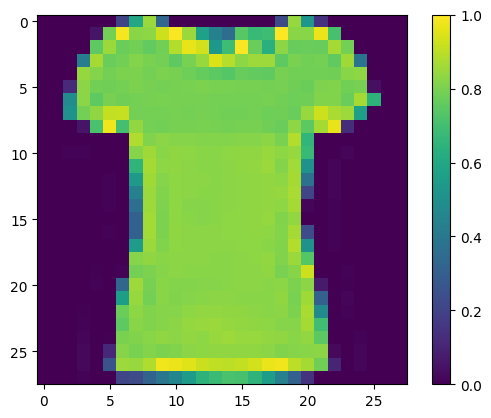

Class: T-shirt/top


In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [4]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2025-01-14 17:42:33--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
140.82.114.4thub.com (github.com)... 
connected. to github.com (github.com)|140.82.114.4|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2025-01-14 17:42:34--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.2’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.08s   

2025-01-14 17:42:34 (5.14 MB/s) - ‘fasionmnist_mlp_params.pkl.2

### Simple 2 Layer Multi Layer Perceptrol using Numpy

In [5]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0 # W_T x Data + B
    lv1 = np.maximum(lv0, 0) # ReLU
    lv2 = lv1 @ w1.T + b1
    return lv2

In [6]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])

print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[ 27.742632 -18.799362 -19.866423 -10.400622 -51.681973 -34.38482
   16.10173  -51.014324 -24.425348 -51.87176 ]]
[0]
NumPy-MLP Prediction: T-shirt/top


### Low-level numpy implementation of the same module

```
Data = (1x 784) 

W = (784 x 128)

Layer 1 : (1 x 128)
```

In [7]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
    
    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)
    
    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)
    
    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    
    return out

result = lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: T-shirt/top


### Constructing an End to End IRModule in TVMScript

#### T.handle

A low-level primitive type in TVM
Represents a ```generic pointer``` to data
Used as a base type for more specific buffer types
Typically not used directly in high-level TVM programming

- It provides flexibility in accepting inputs of different shapes and types
- It acts as an opaque pointer that can be later bound to specific buffer specifications

#### T.buffer

Creates a buffer specification with defined shape and dtype
Used to declare input/output tensors
Example from image:


```B: T.Buffer[(128, 128), "float32"]```

Specifies both the shape (128,128) and data type (float32)

Why didn't we use T.buffer?
Because T.buffer would require specifying the exact shape and type at function definition
Using T.handle allows the function to be more generic and reusable

#### T.match_buffer

Creates a buffer that matches the shape and type of an existing tensor
Used to create views or aliases of existing buffers
Helps in creating buffer bindings without allocating new memory
Often used in transformations and optimizations

```
x = T.handle
X = T.match_buffer(x, (1, m))  # Binds handle 'x' to buffer 'X' with shape (1,m)
```


#### T.alloc_buffer

Allocates a new temporary buffer for intermediate computations
Example from image:

```Y = T.alloc_buffer((128, 128), dtype="float32")```

Used for storing intermediate results during computation
Memory is managed by TVM's runtime system
Commonly used for storing temporary results in complex computations like matrix multiplication


The key distinction is their purpose:

```T.handle``` is the base pointer type
```T.buffer``` declares buffer specifications
```T.match_buffer``` creates views of existing buffers
```T.alloc_buffer``` creates new temporary buffers

In [16]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n), "float32")
        Y = T.match_buffer(y, (1, n), "float32")
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(x: T.handle,
                w: T.handle,
                b: T.handle,
                z: T.handle):
        m, n, k = T.int64(), T.int64(), T.int64()
        X = T.match_buffer(x, (1, m), "float32")
        W = T.match_buffer(w, (n, m), "float32")
        B = T.match_buffer(b, (n, ), "float32")
        Z = T.match_buffer(z, (1, n), "float32")
        Y = T.alloc_buffer((1, n), "float32")
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, "m"), "float32"),
             w0: R.Tensor(("n", "m"), "float32"),
             b0: R.Tensor(("n", ), "float32"),
             w1: R.Tensor(("k", "n"), "float32"),
             b1: R.Tensor(("k", ), "float32")):
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
            lv1 = R.call_dps_packed("relu0", (lv0, ), R.Tensor((1, n), "float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), R.Tensor((1, k), "float32"))
            R.output(out)
        return out

### call_dps_packed

```lv0 = R.call_dps_packed(linear0, (x, w0, b0), (1, 128), dtype="float32")```

To explain what does R.call_dps_packed mean, let us review an equivalent low-level numpy implementation of the operation, as follows:

```
def lnumpy_call_dps_packed(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res
```

Specifically, call_dps_packed takes in a primitive function (prim_func) a list of inputs. Then what it does is allocate an output tensor res, then pass the inputs and the output to the prim_func. After executing prim_func the result is populated in res, then we can return the result.

This is also called ```Destination Passing``` where we pass the destination vector to the function, and result is populated in that.

##### The idea is that input and output are explicitly allocated outside and passed to the low-level primitive function. This style is commonly used in low-level library designs, so higher-level frameworks can handle that memory allocation decision.

### Dataflow Block

Another important element in a relax function is the R.dataflow() scope annotation.

```
with R.dataflow():
    lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
    lv1 = R.call_dps_packed("relu0", (lv0, ), R.Tensor((1, n), "float32"))
    out = R.call_dps_packed("linear0", (lv1, w1, b1), R.Tensor((1, k), "float32"))
    R.output(out)
```

It creates this dataflow or say computation graph on how the data flows. What are the initial inputs, what are intermediate output it generates, then finally the actual output.

In [17]:
IPython.display.Code(MyModule.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def linear0(x: T.handle, w: T.handle, b: T.handle, z: T.handle):
        m = T.int64()
        X = T.match_buffer(x, (1, m))
        n = T.int64()
        W = T.match_buffer(w, (n, m))
        B = T.match_buffer(b, (n,))
        Z = T.match_buffer(z, (1, n))
        # with T.block("root"):
        Y = T.alloc_buffer((1, n))
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0.0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n))
        Y = T.match_buffer(y, (1, n))
        # with T.block("root"):
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0.0))

    @R.function
    def main(x: R.Tensor((1, "m"), dtype="float32"), w0: R.Tensor(("n", "m"), dtype="float32"), b0: R.Tensor(("n",), dtype="float32"), w1: R.Tensor(("k", "n"), dtype="float32"), b1: R.Tensor(("k",), dtype="float32")) -> R.Tensor((1, "k"), dtype="float32"):
        k = T.int64()
        m = T.int64()
        n = T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), out_sinfo=R.Tensor((1, n), dtype="float32"))
            lv1 = R.call_dps_packed("relu0", (lv0,), out_sinfo=R.Tensor((1, n), dtype="float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), out_sinfo=R.Tensor((1, k), dtype="float32"))
            R.output(out)
        return out

In [19]:
from tvm import relax
ex = relax.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm_build.Executable

##### relax.build will gives us the executable.  We can initialize a virtual machine executor that enables us to run the function. Additionally, we will pass in a second argument, indicating which device we want to run the end-to-end executions on.

In [20]:
vm = relax.VirtualMachine(ex, tvm.cpu())

In [21]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [22]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

print(nd_res)

[[ 27.742632 -18.79936  -19.866415 -10.400623 -51.681976 -34.38483
   16.101732 -51.014324 -24.425348 -51.871773]]


In [23]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: T-shirt/top


#### Using existing Libraries

Just like how we used ```linear0``` in the
```
lv0 = R.call_dps_packed("linear0", (x, w0, b0), out_sinfo=R.Tensor((1, n), dtype="float32"))
```

We can also use already existing function in the env, for which we will have to register the function and call them.

#### Things to consider and learnings

##### Relax Func and comptational graph relationship, that is:
- Relax functions represent high-level neural network executions as computational graphs
- Each node represents operations on tensors or program inputs11
- Edges represent data dependencies between operations11
- Variables (like lv0, lv1) represent intermediate tensors

##### Destination Passing Model (DPS)

##### How the relax function stiches the Input and Output, and acts as a computation Graph
